In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from rototransl_env import TrackingEnv

# === POLICY ===
class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim=6, act_dim=3):
        super().__init__()
        self.mean_net = nn.Sequential(
            nn.Linear(obs_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, act_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        mean = self.mean_net(obs)
        std = torch.exp(self.log_std)
        dist = torch.distributions.Normal(mean, std)
        return dist

# === DISCRIMINATORE ===
class Discriminator(nn.Module):
    def __init__(self, obs_dim=6, act_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1), nn.Sigmoid()
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.net(x)

# === UTILS ===
def rollout(policy, env, max_steps=100):
    obs_list, act_list = [], []
    obs, _ = env.reset()
    obs = torch.tensor(obs, dtype=torch.float32)

    for _ in range(max_steps):
        with torch.no_grad():
            dist = policy(obs.unsqueeze(0))
            action = dist.sample().squeeze(0)
        obs_list.append(obs.numpy())
        act_list.append(action.numpy())
        next_obs, _, done, truncated, _, _ = env.step(action)
        if truncated:
            break
        obs = torch.tensor(next_obs, dtype=torch.float32)

    return np.array(obs_list), np.array(act_list)

# === TRAINING LOOP ===
def train_gail(policy, discriminator, expert_data, num_iterations=1000, device="cpu"):
    env = TrackingEnv()
    disc_optim = optim.Adam(discriminator.parameters(), lr=1e-3)
    policy_optim = optim.Adam(policy.parameters(), lr=1e-3)
    
    expert_obs = torch.tensor(expert_data["observations"], dtype=torch.float32)
    expert_acts = torch.tensor(expert_data["actions"], dtype=torch.float32)

    for it in range(num_iterations):
        # 1. Rollout policy
        agent_obs_np, agent_act_np = rollout(policy, env)
        agent_obs = torch.tensor(agent_obs_np, dtype=torch.float32)
        agent_acts = torch.tensor(agent_act_np, dtype=torch.float32)

        # 2. Train discriminator
        disc_optim.zero_grad()

        # --- Prepara batch dello stesso size ---
        N = agent_obs.shape[0]  # numero di step generati dalla policy
        idx = torch.randint(0, expert_obs.shape[0], (N,))
        expert_batch_obs = expert_obs[idx]
        expert_batch_acts = expert_acts[idx]

        # --- Calcola logits ---
        expert_logits = discriminator(expert_batch_obs, expert_batch_acts)
        agent_logits = discriminator(agent_obs, agent_acts)

        # --- Loss ---
        loss_disc = -torch.mean(torch.log(expert_logits + 1e-8) + torch.log(1 - agent_logits + 1e-8))

        loss_disc.backward()
        disc_optim.step()

        # sample azione e log_prob
        dist = policy(agent_obs)
        sampled_action = dist.rsample()
        log_probs = dist.log_prob(sampled_action).sum(dim=-1)

        # reward da D
        with torch.no_grad():
            rewards = -torch.log(1 - discriminator(agent_obs, sampled_action) + 1e-8).squeeze()

        # policy loss
        loss_policy = -(log_probs * rewards).mean()

        # 4. Policy update (simple REINFORCE-style)
        policy_optim.zero_grad()
        loss_policy.backward()
        policy_optim.step()

        print(f"Iter {it} | Disc loss: {loss_disc.item():.4f} | Policy loss: {loss_policy.item():.4f} | Reward mean: {rewards.mean().item():.4f}")

    env.close()
    torch.save(policy.state_dict(), "IL/gail_policy.pth")
    print("\nGAIL training terminato e policy salvata in 'IL/gail_policy.pth'")

# === AVVIO ===
if __name__ == "__main__":
    expert_data = np.load("trajectories/dataset_filtered.npz")
    policy = GaussianPolicy()
    discriminator = Discriminator()
    train_gail(policy, discriminator, expert_data)


Iter 0 | Disc loss: 1.3972 | Policy loss: 3.0969 | Reward mean: 0.7667
Iter 1 | Disc loss: 1.3008 | Policy loss: 3.4887 | Reward mean: 0.8042
Iter 2 | Disc loss: 1.2781 | Policy loss: 3.5301 | Reward mean: 0.8568
Iter 3 | Disc loss: 1.2157 | Policy loss: 3.9049 | Reward mean: 0.8723
Iter 4 | Disc loss: 1.2003 | Policy loss: 3.8974 | Reward mean: 0.8865
Iter 5 | Disc loss: 1.1803 | Policy loss: 3.5962 | Reward mean: 0.8514
Iter 6 | Disc loss: 1.1958 | Policy loss: 3.8364 | Reward mean: 0.8579
Iter 7 | Disc loss: 1.1438 | Policy loss: 3.5377 | Reward mean: 0.7855
Iter 8 | Disc loss: 1.1402 | Policy loss: 3.6861 | Reward mean: 0.8254
Iter 9 | Disc loss: 1.0761 | Policy loss: 2.8109 | Reward mean: 0.6924
Iter 10 | Disc loss: 1.1149 | Policy loss: 3.2748 | Reward mean: 0.7402
Iter 11 | Disc loss: 1.0072 | Policy loss: 2.6784 | Reward mean: 0.6372
Iter 12 | Disc loss: 1.0644 | Policy loss: 2.8292 | Reward mean: 0.6570
Iter 13 | Disc loss: 0.9659 | Policy loss: 2.7057 | Reward mean: 0.5909
It

[Episodio 0] Passi attaccati: pos=0, ang=0, entrambi=0


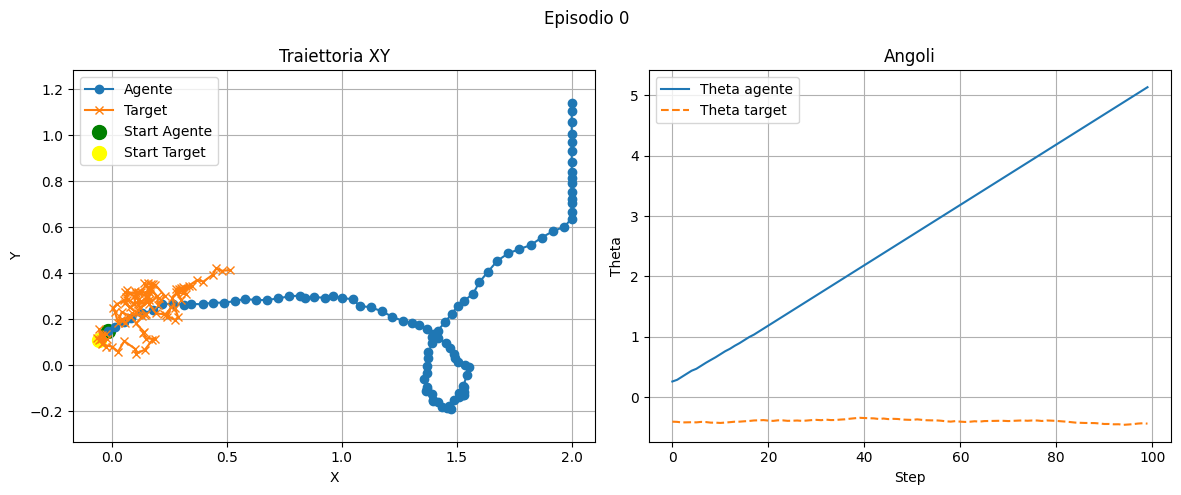

[Episodio 1] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 2] Passi attaccati: pos=1, ang=1, entrambi=0
[Episodio 3] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 4] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 5] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 6] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 7] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 8] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 9] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 10] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 11] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 12] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 13] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 14] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 15] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 16] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 17] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 18] Passi attaccati: pos=0, ang=1, entrambi=0
[

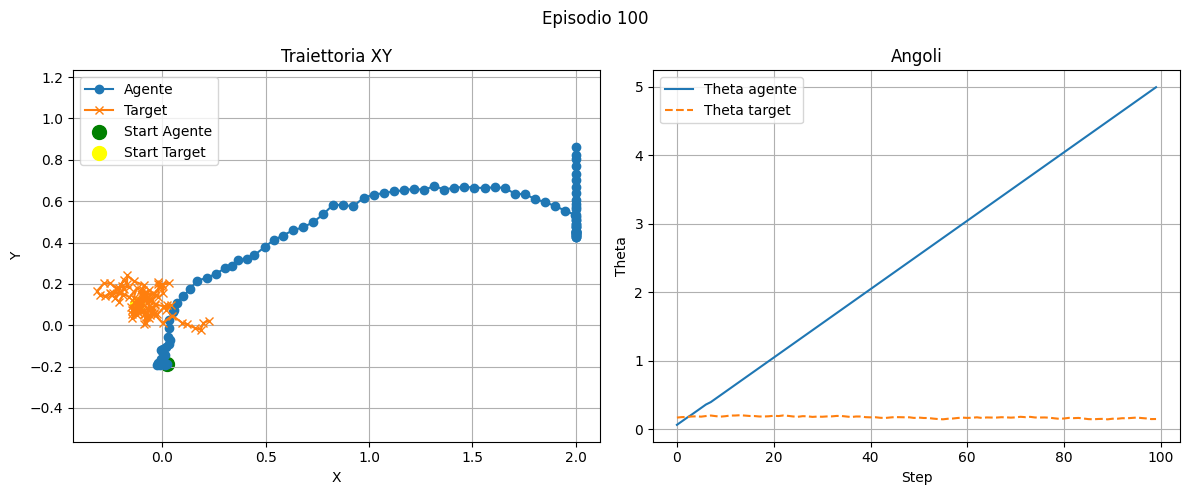

[Episodio 101] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 102] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 103] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 104] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 105] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 106] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 107] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 108] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 109] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 110] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 111] Passi attaccati: pos=1, ang=1, entrambi=0
[Episodio 112] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 113] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 114] Passi attaccati: pos=0, ang=1, entrambi=0
[Episodio 115] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 116] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 117] Passi attaccati: pos=0, ang=0, entrambi=0
[Episodio 118] Passi attaccati:

KeyboardInterrupt: 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from rototransl_env import TrackingEnv
from GAIL import GaussianPolicy

def load_gail_policy(path="IL/gail_policy.pth"):
    model = GaussianPolicy(obs_dim=6, act_dim=3)
    model.load_state_dict(torch.load(path, map_location=torch.device("cpu")))
    model.eval()
    return model

def test_gail_policy(model, num_episodes=1000, tolerance_transl=0.02, tolerance_rot=0.01):
    env = TrackingEnv()
    
    total_attached = 0
    total_attached_transl = 0
    total_attached_rot = 0
    final_distances = []
    final_angle_errors = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)

        trajectory = []
        target_traj = []
        theta_traj = []
        theta_target_traj = []

        done = False
        total_attached_ep = 0
        total_attached_transl_ep = 0
        total_attached_rot_ep = 0

        while not done:
            trajectory.append(state[:2].numpy())
            target_traj.append(state[3:5].numpy())
            theta_traj.append(state[2].item())
            theta_target_traj.append(state[5].item())

            obs = state.unsqueeze(0)
            with torch.no_grad():
                dist = model(obs)  # restituisce una distribuzione
                action = dist.sample().squeeze(0).numpy()

            action = np.clip(action, env.action_space.low, env.action_space.high)

            next_state, _, done, truncated, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            dist_transl = torch.norm(next_state[:2] - state[3:5])
            dist_rot = torch.abs(next_state[2] - state[5])

            if dist_transl < tolerance_transl:
                total_attached_transl_ep += 1
            if dist_rot < tolerance_rot:
                total_attached_rot_ep += 1
            if dist_transl < tolerance_transl and dist_rot < tolerance_rot:
                total_attached_ep += 1

            state = next_state
            done = truncated

        final_distances.append(dist_transl.item())
        final_angle_errors.append(dist_rot.item())
        total_attached += total_attached_ep
        total_attached_transl += total_attached_transl_ep
        total_attached_rot += total_attached_rot_ep

        print(f"[Episodio {ep}] Passi attaccati: pos={total_attached_transl_ep}, ang={total_attached_rot_ep}, entrambi={total_attached_ep}")
        if ep % 100 == 0:
            plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, ep)

    env.close()

    print("\nRisultati aggregati:")
    print(f"Media passi attaccati (traslazione): {total_attached_transl / num_episodes:.2f}")
    print(f"Media passi attaccati (rotazione):    {total_attached_rot / num_episodes:.2f}")
    print(f"Media passi attaccati (entrambi):     {total_attached / num_episodes:.2f}")
    print(f"Distanza media finale:                {np.mean(final_distances):.4f}")
    print(f"Errore medio angolo finale:           {np.mean(final_angle_errors):.4f}")

def plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, episode):
    trajectory = np.array(trajectory)
    target_traj = np.array(target_traj)
    theta_traj = np.array(theta_traj)
    theta_target_traj = np.array(theta_target_traj)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Agente")
    axs[0].plot(target_traj[:, 0], target_traj[:, 1], marker='x', label="Target")
    axs[0].scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Agente', s=100)
    axs[0].scatter(target_traj[0, 0], target_traj[0, 1], color='yellow', label='Start Target', s=100)
    axs[0].set_title("Traiettoria XY")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal')

    axs[1].plot(theta_traj, label="Theta agente")
    axs[1].plot(theta_target_traj, label="Theta target", linestyle='--')
    axs[1].set_title("Angoli")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Theta")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"Episodio {episode}")
    plt.tight_layout()
    plt.show()
    plt.close()

# --- MAIN ---
if __name__ == "__main__":
    policy = load_gail_policy("IL/gail_policy.pth")
    test_gail_policy(policy, num_episodes=1000)
